<b>Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели.  
Цель: В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для
улучшения качества модели.</b>

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
all_data = pd.read_csv('AB_NYC_2019.csv', index_col='id')

In [3]:
all_data = all_data[~all_data.duplicated()]

In [4]:
data = all_data.drop(['name', 'host_id', 'host_name', 'last_review'], axis=1)

In [5]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,
2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
5022,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.5+ MB


#### Только один признак имеет пропуски при заполненнии - "reviews_per_month"

In [7]:
data.describe(include = 'all')

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
unique,5,221,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN
freq,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000


#### По гео-данным видно, что записи действительно сконцентрированны примерно в одном городе, также видно что некоторые признаки имеют достаточно большие максимальные значения, которые сильно превосходят межквартильный размах

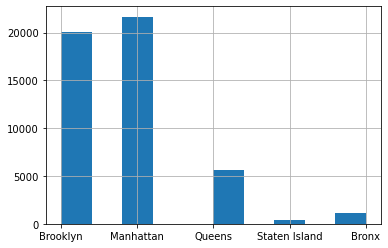

In [8]:
data['neighbourhood_group'].hist()

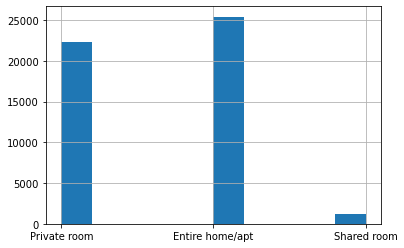

In [9]:
data['room_type'].hist()

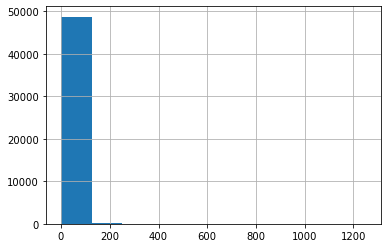

In [10]:
data['minimum_nights'].hist()

In [11]:
data[data['minimum_nights'] > 400].count()

neighbourhood_group               11
neighbourhood                     11
latitude                          11
longitude                         11
room_type                         11
price                             11
minimum_nights                    11
number_of_reviews                 11
reviews_per_month                  5
calculated_host_listings_count    11
availability_365                  11
dtype: int64

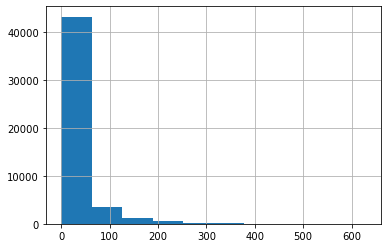

In [12]:
data['number_of_reviews'].hist()

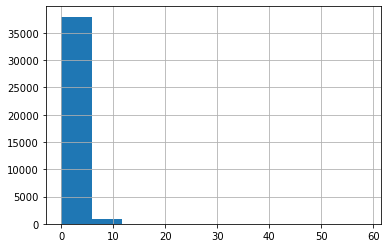

In [13]:
data['reviews_per_month'].hist()

In [14]:
data[data['reviews_per_month'] > 20].count(axis=1)

id
30423106    11
32678719    11
32678720    11
dtype: int64

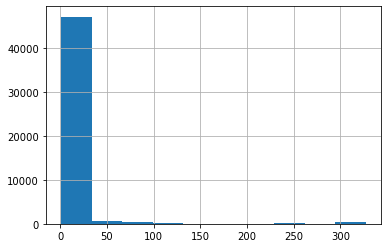

In [15]:
data['calculated_host_listings_count'].hist()

#### Видим значительную концентрацию записей в районе значений 250 и 300

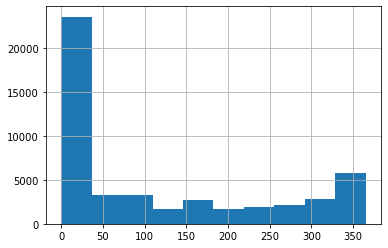

In [16]:
data['availability_365'].hist()

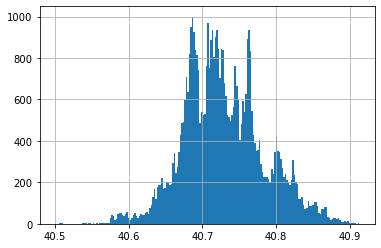

In [17]:
data['latitude'].hist(bins=200)

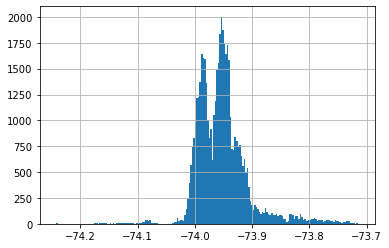

In [18]:
data['longitude'].hist(bins=200)

#### Распределения данных о координатах выглядят как нормальные с 3 и 2 смесями соответственно.

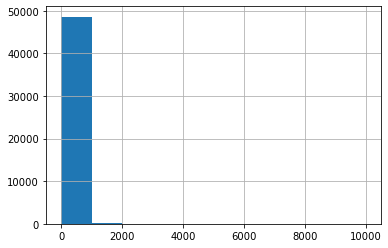

In [19]:
data['price'].hist()

In [20]:
data[data['price'] > 1000].count()

neighbourhood_group               239
neighbourhood                     239
latitude                          239
longitude                         239
room_type                         239
price                             239
minimum_nights                    239
number_of_reviews                 239
reviews_per_month                 107
calculated_host_listings_count    239
availability_365                  239
dtype: int64

#### Варианты с нулевой ценой стоимости аренды - скорее всего ошибка заполнения, уберем эти данные, также уберем единичные выбросы 

In [21]:
mask = data['price'] != 0

In [22]:
data = data[mask]

In [23]:
neighbourhoods_names = data.neighbourhood_group.unique()

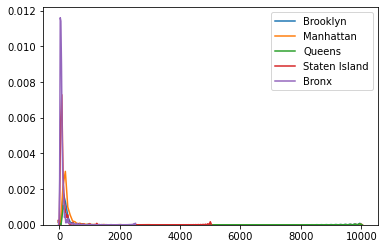

In [24]:
for neighbourhood in neighbourhoods_names:
    sns.kdeplot(data[data['neighbourhood_group'] == neighbourhood]['price'], label = neighbourhood);

In [25]:
room_types = data.room_type.unique()

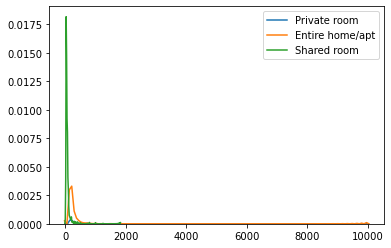

In [26]:
for room_type in room_types:
    sns.kdeplot(data[data['room_type'] == room_type]['price'], label = room_type);

In [27]:
# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
#grid = sns.PairGrid(data=data, height=3)

# Upper is a scatter plot
#grid.map_upper(plt.scatter, color='red', alpha=0.6)

# Diagonal is a histogram
#grid.map_diag(plt.hist, color='red', edgecolor='black')

# Bottom is correlation and density plot
#grid.map_lower(corr_func);
#grid.map_lower(sns.kdeplot, cmap=plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of AirBnB Data', size = 36, y = 1.02);

<Figure size 432x288 with 0 Axes>

In [28]:
data.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.084830,0.033899,0.024893,-0.015357,-0.010117,0.019518,-0.010942
longitude,0.084830,1.000000,-0.149954,-0.062772,0.059015,0.145888,-0.114715,0.082669
price,0.033899,-0.149954,1.000000,0.042805,-0.047926,-0.030575,0.057462,0.081847
minimum_nights,0.024893,-0.062772,0.042805,1.000000,-0.080080,-0.121644,0.127962,0.144275
number_of_reviews,-0.015357,0.059015,-0.047926,-0.080080,1.000000,0.549763,-0.072385,0.171975
reviews_per_month,-0.010117,0.145888,-0.030575,-0.121644,0.549763,1.000000,-0.009431,0.185730
calculated_host_listings_count,0.019518,-0.114715,0.057462,0.127962,-0.072385,-0.009431,1.000000,0.225712
availability_365,-0.010942,0.082669,0.081847,0.144275,0.171975,0.185730,0.225712,1.000000


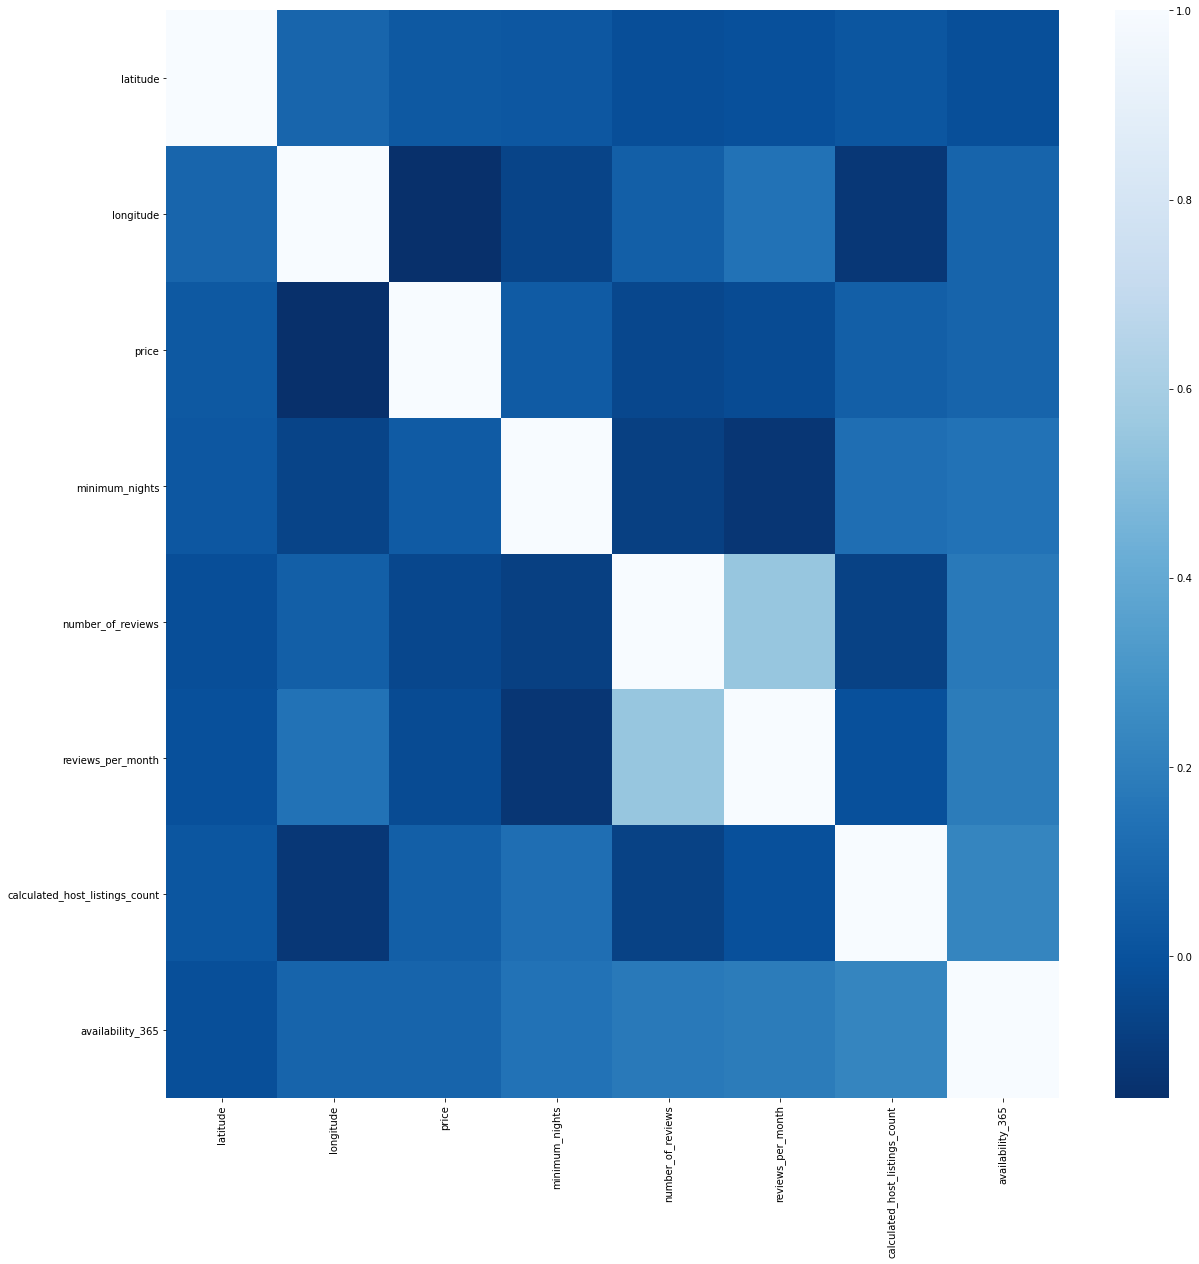

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), cmap='Blues_r')
plt.show()

## Preprocessing & Feature Engineering

### Попробуем прологарифмировать столбец цен

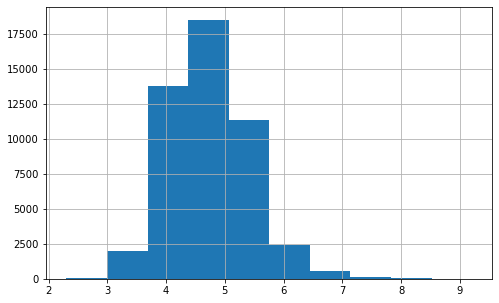

In [30]:
data['price'].apply(np.log).hist(figsize=(8,5))

### Похоже, что данные распределены логнормально

In [31]:
data['log_price'] = data['price'].apply(np.log)

### Добавим признак - расстояние до центра Манхеттана

In [32]:
NY_LAT = 40.78343 
NY_LONG = -73.96625

In [33]:
# Расчет расстояния между двумя точками на сфере (в километрах)
def get_distance(point_1: tuple, point_2: tuple) -> float:
    lat_1 = np.radians(point_1[0])
    long_1 = np.radians(point_1[1])
    
    lat_2 = np.radians(point_2[0])
    long_2 = np.radians(point_2[1])
    
    dlon = long_2 - long_1
    dlat = lat_2 - lat_1
    a = np.sin(dlat / 2)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

In [34]:
data['distance'] = data.apply(lambda x: get_distance((NY_LAT, NY_LONG), (x['latitude'], x['longitude'])), axis=1)

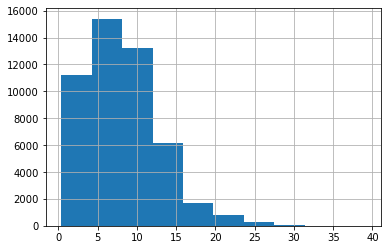

In [35]:
data['distance'].hist()

In [36]:
data[['price', 'log_price']].tail(1)

,price,log_price
id,,
36487245,90,4.49981


#### Посмотрим как распределены цены в зависимости от расстояния, также отметим цветом и метками различные значения районов и типов комнат

In [37]:
plt.rcParams["figure.figsize"] = [15, 10]

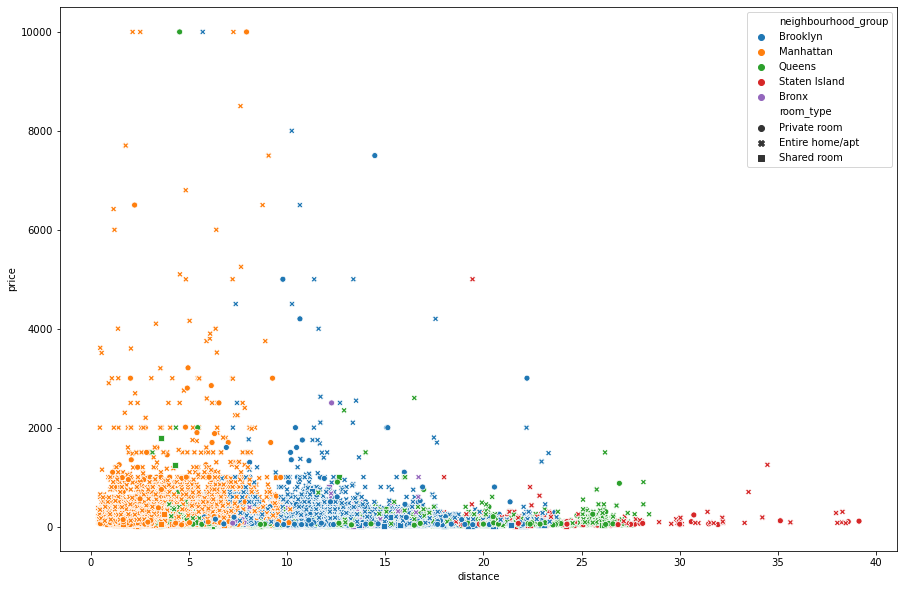

In [38]:
sns.scatterplot(data=data, x='distance', y='price', hue='neighbourhood_group', style='room_type')

### Посмотрим на столбцы - 'number_of_reviews', 'reviews_per_month'. Кажется, они должны быть как-то связаны

In [39]:
data[['number_of_reviews', 'reviews_per_month']]

,number_of_reviews,reviews_per_month
id,,
2539,9,0.21
2595,45,0.38
3647,0,NaN
3831,270,4.64
5022,9,0.10
...,...,...
36484665,0,NaN
36485057,0,NaN
36485431,0,NaN


### Проставим значение 0 в reviews_per_month везде где общее число ревью - 0

In [40]:
data['clear_reviews_per_month'] = data.apply(lambda x: 0 if x['number_of_reviews'] == 0 and np.isnan(x['reviews_per_month']) else x['reviews_per_month'], axis=1)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48884 entries, 2539 to 36487245
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48884 non-null  object 
 1   neighbourhood                   48884 non-null  object 
 2   latitude                        48884 non-null  float64
 3   longitude                       48884 non-null  float64
 4   room_type                       48884 non-null  object 
 5   price                           48884 non-null  int64  
 6   minimum_nights                  48884 non-null  int64  
 7   number_of_reviews               48884 non-null  int64  
 8   reviews_per_month               38833 non-null  float64
 9   calculated_host_listings_count  48884 non-null  int64  
 10  availability_365                48884 non-null  int64  
 11  log_price                       48884 non-null  float64
 12  distance                  

In [42]:
data.price.quantile(q=0.75)

175.0

### Теперь значение частоты ревью присутствует во всех записях

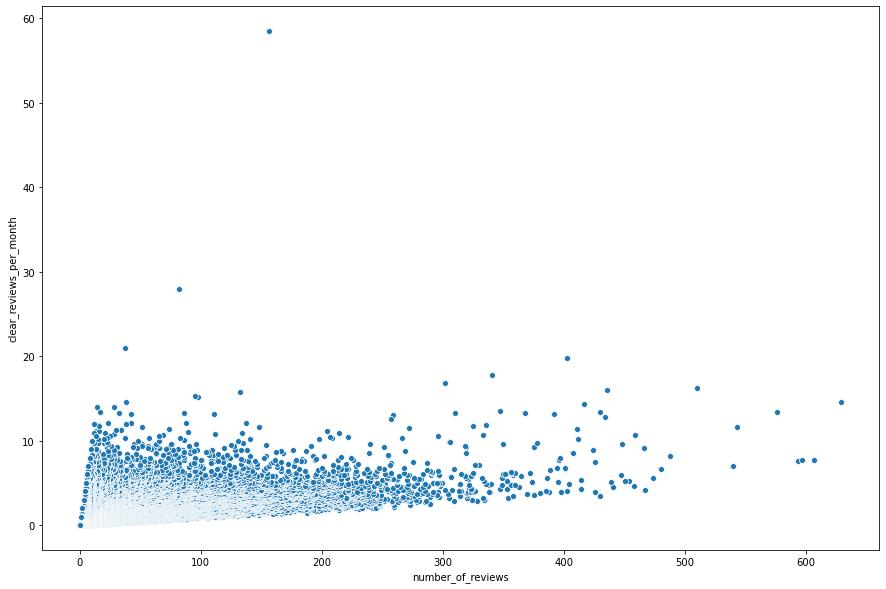

In [43]:
sns.scatterplot(data=data, x='number_of_reviews', y='clear_reviews_per_month')

### Сформируем первый датафрейм и исключим из него ненужные колонки, колонку "price" будем исключать непосредственно перед обучением, чтобы посмотреть на разность логарифмированных данных и обычных

In [44]:
clear_data_1 = data.drop(columns=['latitude', 'longitude', 'reviews_per_month'], axis=1)

In [45]:
clear_data_1.corr()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance,clear_reviews_per_month
price,1.000000,0.042805,-0.047926,0.057462,0.081847,0.638184,-0.119562,-0.050531
minimum_nights,0.042805,1.000000,-0.080080,0.127962,0.144275,0.033236,-0.060842,-0.124870
number_of_reviews,-0.047926,-0.080080,1.000000,-0.072385,0.171975,-0.042319,0.044804,0.589311
calculated_host_listings_count,0.057462,0.127962,-0.072385,1.000000,0.225712,0.132655,-0.070758,-0.047322
availability_365,0.081847,0.144275,0.171975,0.225712,1.000000,0.098844,0.072918,0.163664
log_price,0.638184,0.033236,-0.042319,0.132655,0.098844,1.000000,-0.277667,-0.060307
distance,-0.119562,-0.060842,0.044804,-0.070758,0.072918,-0.277667,1.000000,0.088798
clear_reviews_per_month,-0.050531,-0.124870,0.589311,-0.047322,0.163664,-0.060307,0.088798,1.000000


### Удалим коррелирующий с number_of_reviews признак - clear_reviews_per_month

In [46]:
clear_data = clear_data_1.drop(columns=['clear_reviews_per_month'], axis=1)

In [47]:
clear_data.columns


Index(['neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365', 'log_price', 'distance'],
      dtype='object')

In [48]:
def outlier_detect_IQR(data, col, threshold=3):   
    """Определяем выбросы через интерквартильное расстояние."""
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    params = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col] > Upper_fence, data[col] < Lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
#     print('Количество выбросов в данных:', outlier_index.value_counts()[1])
#     print('Доля выбросов:', outlier_index.value_counts()[1] / len(outlier_index))
    return outlier_index, params

In [49]:
def outlier_detect_MAD(data, col, threshold=3.5):
    """Определяем выбросы через MAD."""
    median = data[col].median()
    median_absolute_deviation = np.median([np.abs(y - median) for y in data[col]])
    modified_z_scores = pd.Series([0.6745 * (y - median) / median_absolute_deviation for y in data[col]])
    outlier_index = np.abs(modified_z_scores) > threshold
    print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    print('Доля выбросов:', outlier_index.value_counts()[1]/len(outlier_index))
    return outlier_index

In [50]:
def drop_outlier(data, outlier_index):
    """Выкидываем выбросы."""
    data_copy = data[~outlier_index]
    return data_copy

In [51]:
def windsorization(data, col, strategy='both', min_val=None, max_val=None):
    """Заменяем все значения большие params[1] значением params[1], а значения меньше params[0] значением params[0].
    При ``strategy = both`` - заменяем снизу и сверху,
        ``strategy = top`` - заменяем только сверху,
        ``strategy = bottom`` - заменяем только снизу."""
    data_copy = data.copy(deep=True)
    if strategy == 'both':
        data_copy.loc[data_copy[col] > max_val, col] = max_val
        data_copy.loc[data_copy[col] < min_val, col] = min_val
    elif strategy == 'top':
        data_copy.loc[data_copy[col] > max_val, col] = max_val
    elif strategy == 'bottom':
        data_copy.loc[data_copy[col] < min_val, col] = min_val
    else:
        raise ValueError(f'strategy - `{strategy}` is not supported')
    return data_copy

In [52]:
index_mad = outlier_detect_MAD(data=clear_data, col='minimum_nights', threshold=10)

Количество выбросов в данных: 538
Доля выбросов: 0.011005646019147369


In [53]:
index_iqr, iqr_params = outlier_detect_IQR(data=clear_data, col='minimum_nights', threshold=3.5)

In [54]:
iqr_params

(19.0, -13.0)

### Установим  ограничения для значений некоторых колонок

In [55]:
cols_to_change = {
    'price': {
        'strategy': 'top',
    }, 
    'minimum_nights': {
        'strategy': 'top',
    }, 
    'number_of_reviews': {
        'strategy': 'top',
    }, 
    'calculated_host_listings_count': {
        'strategy': 'top',
    }, 
    'availability_365': {
        'strategy': 'bottom',
    },
}

clear_data_dropped  - аномальные данные исключены  
clear_data_windowrizated - аномальные данные заменены


In [56]:
clear_data_dropped = clear_data.copy(deep=True)
clear_data_windowrizated = clear_data.copy(deep=True)

In [57]:
clear_data_windowrizated.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,152.755053,7.029887,23.271991,7.144628,112.779498,4.727031,8.214721
std,240.170260,20.512224,44.551331,32.956185,131.627271,0.698225,4.744056
min,10.000000,1.000000,0.000000,1.000000,0.000000,2.302585,0.369737
25%,69.000000,1.000000,1.000000,1.000000,0.000000,4.234107,4.466783
50%,106.000000,3.000000,5.000000,1.000000,45.000000,4.663439,7.671584
75%,175.000000,5.000000,24.000000,2.000000,227.000000,5.164786,11.151092
max,10000.000000,1250.000000,629.000000,327.000000,365.000000,9.210340,39.134388


In [58]:
for col in cols_to_change.keys():
    index_iqr, _ = outlier_detect_IQR(data=clear_data_dropped, col=col, threshold=5)
    clear_data_dropped = drop_outlier(data=clear_data_dropped, outlier_index=index_iqr)

In [59]:
clear_data_dropped.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance
count,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000,40718.000000
mean,133.851073,3.236578,19.706788,1.520777,91.434353,4.687087,8.427160
std,97.268951,3.208929,30.877370,1.087316,121.659727,0.635952,4.766009
min,10.000000,1.000000,0.000000,1.000000,0.000000,2.302585,0.369737
25%,69.000000,1.000000,1.000000,1.000000,0.000000,4.234107,4.762531
50%,100.000000,2.000000,6.000000,1.000000,19.000000,4.605170,7.856995
75%,170.000000,4.000000,24.000000,2.000000,168.000000,5.135798,11.304703
max,700.000000,25.000000,157.000000,7.000000,365.000000,6.551080,39.134388


### Как видно, было удалено около 20% данных, что наверное много, но все равно посмотрим на результат обучения

In [60]:
for col, params in cols_to_change.items():
    _, iqr_params = outlier_detect_IQR(data=clear_data, col=col, threshold=5)
    strategy = params['strategy']
    clear_data_windowrizated = windsorization(
        data=clear_data_windowrizated, 
        col=col, 
        strategy=strategy, 
        min_val=iqr_params[1],
        max_val=iqr_params[0],
    )

In [61]:
clear_data_windowrizated.describe()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance
count,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,142.955425,5.450372,21.131986,1.986703,112.779498,4.727031,8.214721
std,116.674121,7.307749,34.628470,1.827086,131.627271,0.698225,4.744056
min,10.000000,1.000000,0.000000,1.000000,0.000000,2.302585,0.369737
25%,69.000000,1.000000,1.000000,1.000000,0.000000,4.234107,4.466783
50%,106.000000,3.000000,5.000000,1.000000,45.000000,4.663439,7.671584
75%,175.000000,5.000000,24.000000,2.000000,227.000000,5.164786,11.151092
max,705.000000,25.000000,139.000000,7.000000,365.000000,9.210340,39.134388


### Преобразуем категориальные признаки

#### попробуем начать c dummy

In [87]:
dummy_data_dropped = pd.get_dummies(clear_data_dropped, drop_first=True)
dummy_data_windowrizated = pd.get_dummies(clear_data_windowrizated, drop_first=True)

### Исключаем колонку цены, оставляя только ее логарифм

In [88]:
dummy_data_dropped_log = dummy_data_dropped.drop(columns=['price'], axis=1)
dummy_data_windowrizated_log = dummy_data_windowrizated.drop(columns=['price'], axis=1)

In [89]:
dummy_data_dropped.head(1)

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,,,,,,
2539,149,1,9,6,365,5.003946,15.124636,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## Modeling

In [90]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats


measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [91]:
def get_encoded_data(input_data: pd.DataFrame, target_name: str, encoder_slug: str, **kwargs) -> pd.DataFrame:
    if encoder_slug == 'dummy':
        return pd.get_dummies(input_data, drop_first=True)
    else:
        X_train, _, y_train, _ = train_test_split(
            input_data, 
            input_data[target_name], 
            test_size=0.3
        )
        if encoder_slug == 'ordinal':
            ord_enc = ce.OrdinalEncoder(cols=kwargs['encoded_cols']).fit(X_train, y_train)
            return ord_enc.transform(input_data)
        elif encoder_slug == 'catboost':
            catboost_enc = ce.CatBoostEncoder(cols=kwargs['encoded_cols']).fit(X_train, y_train)
            return catboost_enc.transform(input_data)
    raise ValueError(f'{encoder_slug} is not available encoder slug')

In [92]:
def show_reuslts(
    data: pd.DataFrame, 
    target_name: str, 
    scaler_class: type, 
    encoder_slug: str, 
    encoded_cols: list = None
) -> dict:
    data = data.copy(deep=True)
    measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
    measured_metrics.set_index("error_type")    
    
    # Encode string columns
    data = get_encoded_data(data, target_name, encoder_slug, encoded_cols=encoded_cols)
    
    
    # Split encoded data
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop([target_name], axis=1), 
        data[target_name], 
        test_size=0.3
    )
    
    # Base line
    y_median = np.median(y_train)
    y_pred_naive = np.ones(len(y_test)) * y_median
    measured_metrics['naive_baseline'] = dataframe_metrics(y_test, y_pred_naive)
    
    # Liner Models
    scaler = scaler_class()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[X_train.columns] = scaler.fit_transform(X_train)
    X_test_scaled[X_train.columns] = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    measured_metrics['lr'] = dataframe_metrics(y_test, lr.predict(X_test_scaled))
    
    # Lasso
    lasso_cv = LassoCV(cv=5)
    lasso_cv.fit(X_train_scaled, y_train)
    measured_metrics['lasso_cv'] = dataframe_metrics(y_test, lasso_cv.predict(X_test_scaled))
    
    # Ridge
    ridge_cv = RidgeCV(cv=5)
    ridge_cv.fit(X_train_scaled, y_train)
    measured_metrics['ridge_cv'] = dataframe_metrics(y_test, ridge_cv.predict(X_test_scaled))
    
    # Elastic
    elastic_cv = ElasticNetCV()
    elastic_cv.fit(X_train_scaled, y_train)
    measured_metrics['elastic_cv'] = dataframe_metrics(y_test, elastic_cv.predict(X_test_scaled))

    
    # Trees
    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    measured_metrics['rf'] = dataframe_metrics(y_test, rf.predict(X_test))
    
    # RandomizedSearchCV
    params = {
        'n_estimators':[10, 25, 50],
        'max_depth':[2, 5, 7, 10],
        'max_features':[
            'auto', 
            X_train.shape[1]//2, 
            'sqrt',
            'log2'
        ]
    }

    rscv = RandomizedSearchCV(
        estimator=RandomForestRegressor(),
        param_distributions = params,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    rscv.fit(X_train, y_train)
    
    rscv.best_estimator_.fit(X_train, y_train)
    measured_metrics['rf_cv'] = dataframe_metrics(y_test, rscv.best_estimator_.predict(X_test))
    
    return measured_metrics

### Посмотрим какая точность достигается с помошью различных способов масштабирования данных

#### Начнем с данных с удаленными аномальными значениями

In [93]:
show_reuslts(data=dummy_data_dropped_log, target_name='log_price', scaler_class=StandardScaler,  encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.2s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.513348,8.444897e+07,0.313722,0.313632,0.313725,0.313429,0.307121
1,RMSE,0.637334,9.333808e+09,0.411281,0.411307,0.411282,0.412706,0.405136
2,R2,-0.017202,-2.181681e+20,0.576406,0.576352,0.576403,0.573465,0.588967
3,MAPE,11.016549,1.938366e+09,6.747193,6.742649,6.747471,6.728013,6.598795


In [94]:
show_reuslts(data=dummy_data_dropped_log, target_name='log_price', scaler_class=RobustScaler, encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.5s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.519319,1.409111e+05,0.315620,0.314558,0.315848,0.312678,0.309363
1,RMSE,0.643079,1.555141e+07,0.417182,0.416023,0.417421,0.416100,0.410393
2,R2,-0.017123,-5.948185e+14,0.571947,0.574323,0.571458,0.574166,0.585767
3,MAPE,11.151499,2.813402e+06,6.794087,6.769838,6.800013,6.721470,6.654912


In [95]:
show_reuslts(data=dummy_data_dropped_log, target_name='log_price', scaler_class=MinMaxScaler, encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   42.9s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.513593,2.429102e+06,0.311115,0.310258,0.311273,0.310477,0.306070
1,RMSE,0.637142,1.857048e+08,0.409595,0.408791,0.409832,0.409498,0.403832
2,R2,-0.021617,-8.678831e+16,0.577793,0.579449,0.577306,0.577994,0.589591
3,MAPE,10.968532,5.786273e+07,6.651116,6.629021,6.655186,6.633878,6.544874


#### Теперь посмотрим как ведут себя данные с заменой аномальных значений

In [96]:
show_reuslts(data=dummy_data_windowrizated_log, target_name='log_price', scaler_class=StandardScaler,  encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.0s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.551630,7.228400e+09,0.336357,0.336079,0.336411,0.326468,0.326377
1,RMSE,0.700623,4.377039e+11,0.466878,0.466623,0.466932,0.459684,0.457100
2,R2,-0.008893,-3.937657e+23,0.551995,0.552482,0.551890,0.565693,0.570564
3,MAPE,11.715299,1.528253e+11,7.045892,7.038197,7.047452,6.837642,6.835363


In [97]:
show_reuslts(data=dummy_data_windowrizated_log, target_name='log_price', scaler_class=RobustScaler, encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   54.8s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.550685,4.116874e+04,0.337478,0.336680,0.337581,0.326857,0.327504
1,RMSE,0.702090,2.878454e+06,0.471419,0.471134,0.471571,0.461969,0.459816
2,R2,-0.013147,-1.702962e+13,0.543227,0.543780,0.542932,0.561357,0.565435
3,MAPE,11.635767,8.876367e+05,7.037356,7.014828,7.040414,6.817615,6.832689


In [98]:
show_reuslts(data=dummy_data_windowrizated_log, target_name='log_price', scaler_class=MinMaxScaler, encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.6s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.555354,1.946318e+06,0.338193,0.337612,0.338281,0.327251,0.327121
1,RMSE,0.702115,1.307763e+08,0.469138,0.468010,0.469323,0.457915,0.456179
2,R2,-0.002853,-3.479200e+16,0.552263,0.554414,0.551911,0.573430,0.576657
3,MAPE,11.911806,4.661899e+07,7.151769,7.135725,7.154636,6.920125,6.914628


### Данные с исключенными аномалиями ведут себя лучше, MinMaxScaler - показал наилучшие результаты

### Мы работали с логарифмированными ценами, попробуем теперь посмотреть на точность предсказания для нелогарифмированных цен

In [99]:
dummy_data_dropped_not_log = dummy_data_dropped.drop(columns=['log_price'], axis=1)
dummy_data_windowrizated_not_log = dummy_data_windowrizated.drop(columns=['log_price'], axis=1)

In [100]:
dummy_data_dropped_not_log.head(1)

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,distance,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,...,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,,,,,,
2539,149,1,9,6,365,15.124636,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [101]:
show_reuslts(data=dummy_data_dropped_not_log, target_name='price', scaler_class=MinMaxScaler, encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   45.5s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,65.422724,8.125626e+08,47.146364,47.229135,48.448708,46.416263,45.172177
1,RMSE,102.618780,4.489378e+10,73.555009,73.519048,76.103157,73.644160,72.083379
2,R2,-0.119417,-2.142448e+17,0.424875,0.425437,0.384337,0.423480,0.447658
3,MAPE,52.681899,8.473287e+08,40.064138,40.203861,43.690600,38.737319,38.212545


In [102]:
show_reuslts(data=dummy_data_windowrizated_not_log, target_name='price', scaler_class=MinMaxScaler, encoder_slug='dummy')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.8s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,74.791354,2.427780e+08,56.104636,56.187445,57.454012,53.047326,52.617485
1,RMSE,123.237322,2.078979e+10,93.457433,93.368118,96.137347,90.587725,89.644445
2,R2,-0.096197,-3.119640e+16,0.369577,0.370781,0.332904,0.407698,0.419969
3,MAPE,57.544899,2.043775e+08,43.263897,43.433447,47.332993,39.413645,39.867748


### Сравним точность логарифмированных данных и обычных

### Рассмотрим подробнее лучший вариант - RandomForest, с MAE ~ 0.31

### Учитывая, что мы предсказыает логарифм цены, то в абсолютных числах ошибку можно вычислить так:
#### для нашего доверительного интервала справедливо
```
y_pred - предсказанное с помощью нашей модели значение
y_true - истинное значение цены для входных данных

ln(y_pred) - 0.31 < y_true < ln(y_pred) + 0.31
ln(y_pred) - 0.31 < ln(y_true) < ln(y_true) + 0.31
ln(y_pred) - 0.31 < ln(y_true) < ln(y_pred) + 0.31
ln(y_pred) - log(e^0.31) < ln(y_true) < ln(y_pred) + ln(e^0.31)
ln(y_pred/e^0.31) < ln(y_true) < ln(y_pred*e^0.31)

e^0.31 ~ 1.36

```
### Таким образом итоговая погрешность для логарифмированных данных составила +- 36%, в то время как для нелогарифмированных +-53 (доллара), учитывая медианное значение цены - 100 (долларов) это примерно +-50%, таким образом можно сделать вывод о том, что лучше перед обучением логарифмировать целевую переменную

In [112]:
clear_data_best_dropped = clear_data_dropped.drop(columns=['price'], axis=1)
clear_data_best_windowdrised = clear_data_windowrizated.drop(columns=['price'], axis=1)

### Теперь посмотрим как точность предсказания зависит от энкодинга категориальных признаков

In [113]:
clear_data_best.head(1)

,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance
id,,,,,,,,,
2539,Brooklyn,Kensington,Private room,1,9,6,365,5.003946,15.124636


In [114]:
encoded_cols = ['neighbourhood_group', 'neighbourhood', 'room_type']

In [115]:
show_reuslts(
    data=clear_data_best_dropped, 
    target_name='log_price', 
    scaler_class=StandardScaler, 
    encoder_slug='ordinal', 
    encoded_cols=encoded_cols
)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.521340,0.375575,0.375623,0.375588,0.375636,0.315730,0.310738
1,RMSE,0.648136,0.509751,0.509778,0.509754,0.509781,0.416262,0.410898
2,R2,-0.018533,0.369974,0.369908,0.369967,0.369901,0.579878,0.590635
3,MAPE,11.177444,8.181751,8.182728,8.182043,8.182999,6.788225,6.680875


In [116]:
show_reuslts(
    data=clear_data_best_dropped, 
    target_name='log_price', 
    scaler_class=StandardScaler, 
    encoder_slug='catboost', 
    encoded_cols=encoded_cols
)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.509281,0.312862,0.312844,0.312859,0.312841,0.309926,0.299133
1,RMSE,0.633221,0.411149,0.411129,0.411147,0.411127,0.410449,0.396376
2,R2,-0.018125,0.570770,0.570812,0.570776,0.570817,0.572230,0.601063
3,MAPE,10.907900,6.714754,6.714567,6.714724,6.714536,6.650995,6.413061


In [117]:
show_reuslts(
    data=clear_data_best_windowdrised, 
    target_name='log_price', 
    scaler_class=StandardScaler, 
    encoder_slug='ordinal', 
    encoded_cols=encoded_cols
)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.5s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.555439,0.364934,0.364888,0.364933,0.364886,0.327675,0.322908
1,RMSE,0.702680,0.499529,0.499517,0.499530,0.499520,0.457416,0.449864
2,R2,-0.005112,0.492051,0.492075,0.492048,0.492069,0.574085,0.588034
3,MAPE,11.888778,7.725342,7.724515,7.725349,7.724537,6.930211,6.818668


In [118]:
show_reuslts(
    data=clear_data_best_windowdrised, 
    target_name='log_price', 
    scaler_class=StandardScaler, 
    encoder_slug='catboost', 
    encoded_cols=encoded_cols
)

/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.6s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.553478,0.337424,0.337398,0.337421,0.337395,0.324475,0.316757
1,RMSE,0.700812,0.471970,0.471974,0.471970,0.471974,0.458657,0.447905
2,R2,-0.002491,0.545319,0.545312,0.545319,0.545312,0.570608,0.590504
3,MAPE,11.886119,7.107522,7.107229,7.107532,7.107256,6.843426,6.676545


### Наилучший результат для линейных моделей достигается на данных с удаленными аномалиями, логарифмированной ценой и применением алгоритма "catboost" для энкодинга строковых значений

### Все линейные модели показали примерно одинаковый результат, давайте возьмем одну из них и посмотрим на веса признаков